In [4]:
import cv2
import glob
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import numpy as np

import dask

import time


In [5]:
# zip folder containing all the images that are in original_crop folder
folder = 'original_crop'
zip_name = folder + '.zip'
zip_folder = os.path.join(os.getcwd(), zip_name)
print(zip_folder)

# now zip the folder
import shutil
shutil.make_archive(folder, 'zip', folder)

    # remove the original folder
shutil.rmtree(folder)



/home/tomas/Nextcloud/SYNC/BIO/preprocess/original_crop.zip


In [7]:
# get all files from train_preprocessed folder
files = glob.glob('train_preprocessed/*')
files


['train_preprocessed/3894_right.png',
 'train_preprocessed/17875_right.png',
 'train_preprocessed/37059_left.png',
 'train_preprocessed/19892_right.png',
 'train_preprocessed/23907_left.png',
 'train_preprocessed/13584_right.png',
 'train_preprocessed/37827_left.png',
 'train_preprocessed/1596_left.png',
 'train_preprocessed/36346_right.png',
 'train_preprocessed/13874_left.png',
 'train_preprocessed/38205_right.png',
 'train_preprocessed/9487_left.png',
 'train_preprocessed/34321_right.png',
 'train_preprocessed/28155_left.png',
 'train_preprocessed/33876_left.png',
 'train_preprocessed/28507_right.png',
 'train_preprocessed/184_right.png',
 'train_preprocessed/617_right.png',
 'train_preprocessed/14504_left.png',
 'train_preprocessed/761_right.png',
 'train_preprocessed/28118_right.png',
 'train_preprocessed/11914_right.png',
 'train_preprocessed/25330_right.png',
 'train_preprocessed/10042_left.png',
 'train_preprocessed/43746_left.png',
 'train_preprocessed/7603_left.png',
 'train_

In [60]:
data = glob.glob('../train.zip')
import sys

# unzip the data
import zipfile
file1 = zipfile.ZipFile(data[0])

# open the zip file
# file = zipfile.ZipFile(data[0])
# get the names of all files in the zip archive
file1

# get the names of all files in the zip archive
len(file1.namelist())

# # remove all before the first /
# file = [file.split('/')[1] for file in file1.namelist()]
# file

# # remove .jpeg from the file names
# file = [file.split('.')[0] for file in file]
# file







#open the

35127

In [55]:
def get_binary_mask(img):
    """
    Get mask for image.
    Args:
        img: Origin image.
    Returns:
        mask: Mask for image.
    """
    
    if img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    threhold = np.mean(gray_img)/3-5
    _, mask = cv2.threshold(gray_img, max(0,threhold), 1, cv2.THRESH_BINARY)
    nn_mask = np.zeros((mask.shape[0]+2,mask.shape[1]+2),np.uint8)
    new_mask = (1-mask).astype(np.uint8)
    _,new_mask,_,_ = cv2.floodFill(new_mask, nn_mask, (0,0), (0), cv2.FLOODFILL_MASK_ONLY)
    _,new_mask,_,_ = cv2.floodFill(new_mask, nn_mask, (new_mask.shape[1]-1,new_mask.shape[0]-1), (0), cv2.FLOODFILL_MASK_ONLY)
    mask = mask + new_mask

    # create kernel for morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,  20))

    # morphological opening operation
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    return mask

def get_mask(img):
    """
    Get mask for image.
    Args:
        img: Origin image.
    Returns:
        tmp_mask: Mask for image.
        bbox: Bounding box for image.
        center: Center of image.
        radius: Radius of image.
    """

    # get gray image 
    if img.ndim == 3:
        gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    elif img.ndim == 2:
        gray_img =img.copy()
    else:
        raise 'image dim is not 1 or 3'


    h,w = gray_img.shape
    shape=gray_img.shape[0:2]

    # resize image
    gray_img = cv2.resize(gray_img,(0,0),fx = 0.5,fy = 0.5)

    # normalize image
    tgray_img=cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)

    tmp_mask= get_binary_mask(tgray_img)

    center=get_center_from_edge_of_mask(tmp_mask)
    radius=get_radius_from_mask_center(tmp_mask,center)
    if radius==-1:
        cv2.imwrite('error_img.png',img)
        cv2.imwrite('error_mask.png',tmp_mask)

        print('\n\n\n\n',img.shape, center,'\n\n')

        raise 'error in get_mask' 
    
    



def get_center_from_edge_of_mask(mask):
    """
    Get center for image.
    Args:
        mask: Mask for image.
    Returns:
        center: Center for image.
    """

    center=[0,0]
    x=mask.sum(axis=1)
    center[0]=np.where(x>x.max()*0.95)[0].mean()
    x=mask.sum(axis=0)
    center[1]=np.where(x>x.max()*0.95)[0].mean()
    return center
    # @dask.delayed    
def get_radius_from_mask_center(mask,center):
    """
    Get radius for image.
    Args:
        mask: Mask for image.
        center: Center for image.
    Returns:
        radius: Radius for image.
    """

    mask=mask.astype(np.uint8)
    kernel_size=max(mask.shape[1]//400*2+1,3)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    mask=cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    index=np.where(mask>0)
    b=np.sqrt((index[0]-center[0])**2+(index[1]-center[1])**2) # sqrt((x-x0)^2+(y-y0)^2)
    b_count=np.bincount(np.ceil(b).astype(np.int32))
    try:
        radius=np.where(b_count>b_count.max()*0.995)[0].max()
    except:
        print('error in get_radius_from_mask_center\n\n', center, '\n\n', b_count, '\n\n')
        # radius= length from center to top or bottom of image
        radius = mask.shape[0] - center[0]
        print('radius = ', radius)
        # radius = 
    print('radius = ', radius)
    return radius

train/24798_left.jpeg
radius =  521


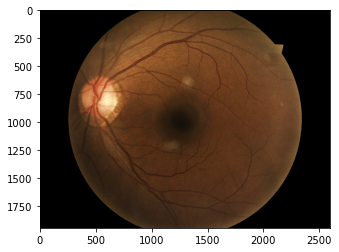

train/32078_right.jpeg
radius =  753


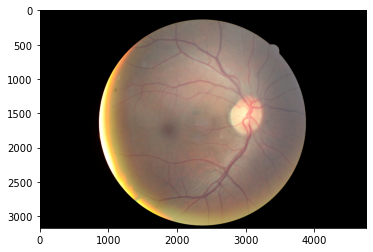

train/1419_left.jpeg
radius =  526


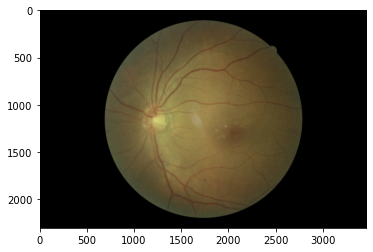

train/32251_left.jpeg
radius =  578


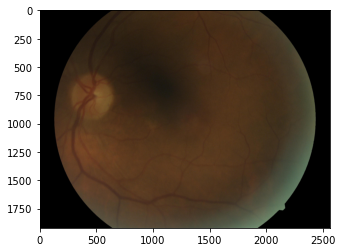

train/42238_right.jpeg
radius =  740


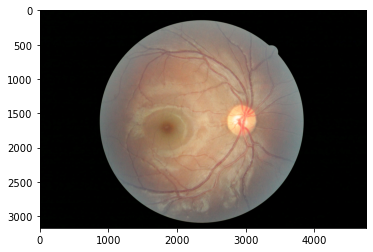

train/32801_right.jpeg
radius =  564


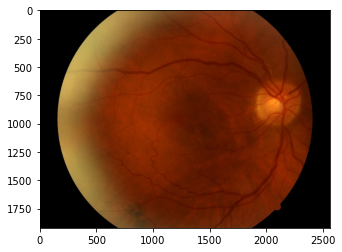

train/13505_left.jpeg
radius =  730


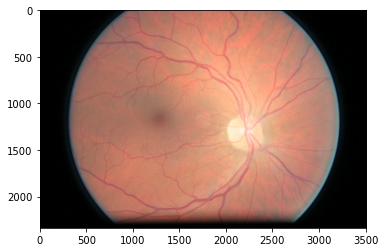

train/1452_right.jpeg
radius =  800


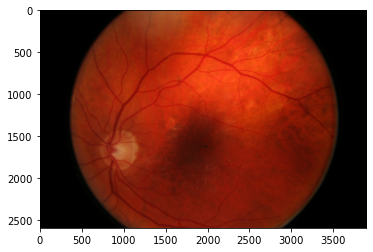

train/7596_right.jpeg
radius =  805


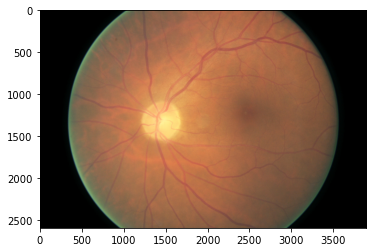

train/15337_left.jpeg
error in get_radius_from_mask_center

 [647.5, 967.5] 

 [] 


radius =  648.5
radius =  648.5


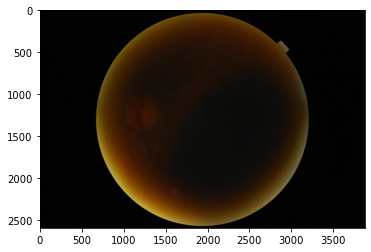

train/22045_right.jpeg
radius =  886


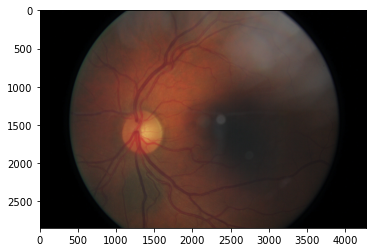

train/29221_left.jpeg
radius =  724


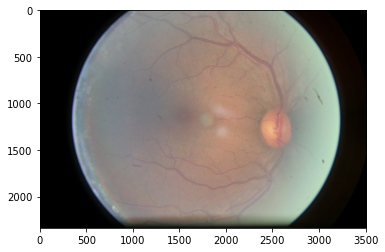

train/19414_left.jpeg
radius =  605


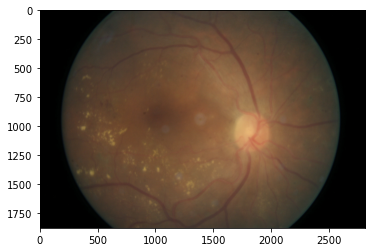

train/24391_left.jpeg
radius =  690


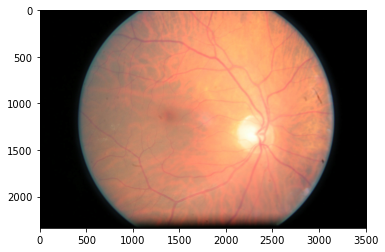

train/21629_right.jpeg
radius =  468


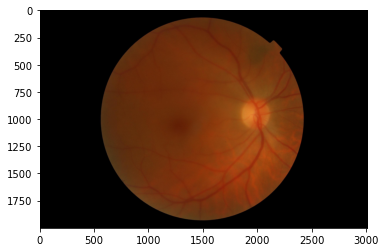

train/3907_right.jpeg
radius =  791


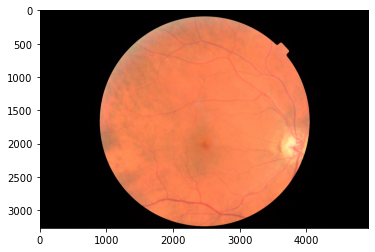

train/40764_right.jpeg
error in get_radius_from_mask_center

 [647.5, 967.5] 

 [] 


radius =  648.5
radius =  648.5


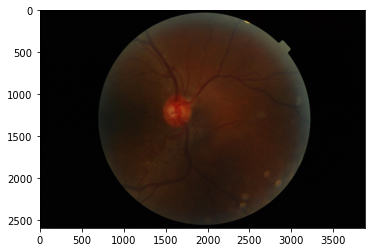

train/20489_right.jpeg
radius =  750


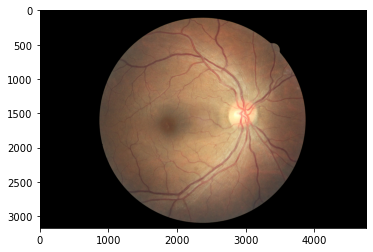

train/43998_right.jpeg
radius =  741


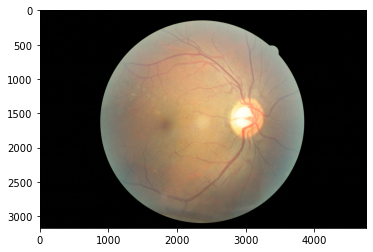

In [58]:
# find files that are not in the zip file
files = glob.glob('train_preprocessed/*')
files

# get the names of all files in the zip archive

# remove all before first /
files = [file.split('/')[1] for file in files]
files

# remove all after .jpg
files = [file.split('.')[0] for file in files]
files


# find files that are not in files but are in file
files_to_remove = list(set(file) - set(files))
files_to_remove

# show the files that are not in the zip file
files_to_remove = ['train/' + file + '.jpeg' for file in files_to_remove]
files_to_remove


data = glob.glob('../train.zip')
# remove first item
files_to_remove.pop(0)
files_to_remove

file_read = zipfile.ZipFile(data[0])
for file in files_to_remove:
    print(file)
    # plt show the image
    img = plt.imread(file_read.open(file))

    get_mask(img)

    plt.imshow(img)
    plt.show()

    


In [11]:

# get the first 100 images
for i in range(1,101):
    img = file.open(file.namelist()[i])
    img = plt.imread(img)
    plt.imsave(os.path.join(folder, str(i) + '.jpeg'), img)
    # plt.imshow(img)
    # plt.show()

# zip folder containing all the images that are in original_crop folder
zip_name = folder + '.zip'
zip_folder = os.path.join(os.getcwd(), zip_name)
print(zip_folder)

# now zip the folder
shutil.make_archive(folder, 'zip', folder)

    # remove the original folder



/home/tomas/Nextcloud/SYNC/BIO/preprocess/original_crop.zip


'/home/tomas/Nextcloud/SYNC/BIO/preprocess/original_crop.zip'

In [61]:
def preprocess(preprocessor,file_handler, images, source_path):
    
    # dask_array = []
    for image_path in images:
        dst_image = os.path.splitext(image_path.split('/')[-1])[0]+'.png'
        path = os.path.join(source_path, dst_image)

        if os.path.exists(path):
            print('\033[34m' + 'file ' + path + ' already exists...' + '\033[0m')
            continue
        # try:
        img = file_handler.image_read(image_path)

        preprocessed_image = preprocessor.get_image_without_background(img)
        # plt.imshow(preprocessed_image)
        # plt.show()

        # preprocessed_image = 

        # final =  file_handler.image_write(path, preprocessed_image)
        file_handler.image_write(path, preprocessed_image)
        file_handler.image_write_to_zip(path, preprocessed_image)
        # dask_array.append(final)

    


        # except:
        #     print('\033[31m' + 'failed' + '\033[0m', image_path)
        #     continue
    # return dask_array

        



In [13]:
total.visualize()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [83]:
file_handler = FileHandler()

images = glob.glob(os.path.join('./original_img', '*.jpeg'))
save_path = file_handler.fold_dir('./original_crop')
#remove original crop folder
for image_path in images:
    dst_image = os.path.splitext(image_path.split('/')[-1])[0]+'.png'
    path = os.path.join(save_path, dst_image)
    if os.path.exists(path):
        os.remove(path)

preprocessor = Preprocessor()
preprocess(preprocessor,file_handler, images, save_path)


        


In [16]:
file_handler = FileHandler()
preprocessor = Preprocessor()

images = glob.glob(os.path.join('./original_img', '*.jpeg'))
save_path = file_handler.fold_dir('./original_crop')

for image_path in images:
    dst_image = os.path.splitext(image_path.split('/')[-1])[0]+'.png'
    path = os.path.join(save_path, dst_image)
    if os.path.exists(path):
        os.remove(path) 


In [25]:

# use dask to parallelize
dask_object = []
print(dask_object)


dask_object = preprocess(preprocessor, file_handler, images, save_path)

dask_object


[]


[Delayed('image_write-46db072c-77f0-4708-97b7-e5bf442ebfd4'),
 Delayed('image_write-d625f0eb-4285-4a8b-a1f1-fcb17e059fd8'),
 Delayed('image_write-69081375-117d-4ec2-815a-2b3bc314c261'),
 Delayed('image_write-38602faa-c1b9-4a79-bb10-950c789b8a5a'),
 Delayed('image_write-5a8062cf-dd16-498c-bcc7-ab5091e6e2c7')]

In [26]:


total = dask.delayed(dask_object)
total.compute()
# preprocess(preprocessor, images, save_path)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Delayed'

In [27]:
bar = Bar('Processing', max=100)

for i in range(100):
    time.sleep(0.1)
    bar.next()
bar.finish()

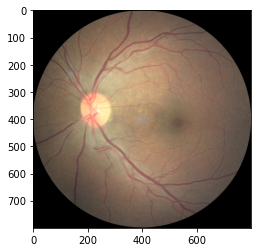

./train_preprocessed/10003_left.png


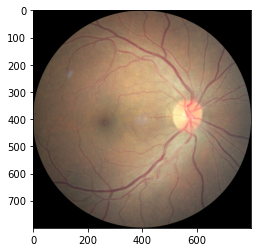

./train_preprocessed/10003_right.png


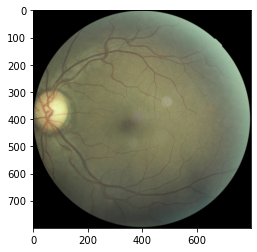

./train_preprocessed/10007_left.png


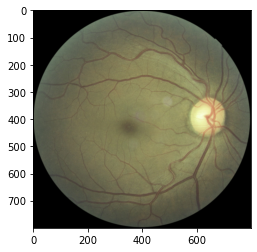

./train_preprocessed/10007_right.png


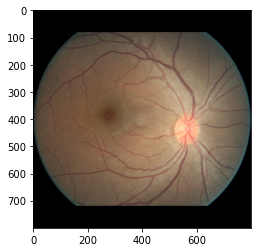

./train_preprocessed/10009_left.png


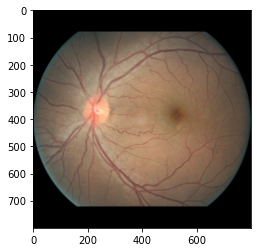

./train_preprocessed/10009_right.png


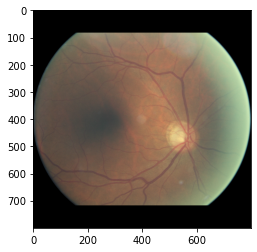

./train_preprocessed/1000_left.png


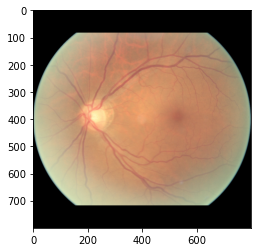

./train_preprocessed/1000_right.png


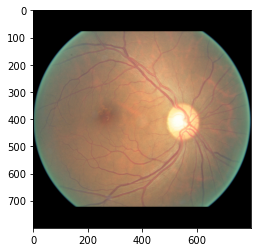

./train_preprocessed/10010_left.png


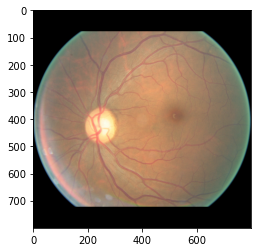

./train_preprocessed/10010_right.png


In [114]:
def preprocess(preprocessor,file_handler, bar, file, source_path):
    
#     # dask_array = []
    # print(len(file.namelist()), 'images in the zip file', source_path)

    
# # open the zip file
# # file = zipfile.ZipFile(data[0])
# # get the names of all files in the zip archive
# file

# # get the names of all files in the zip archive
# file.namelist()

# print(len(file.namelist()), 'images in the zip file')

# #open the first image in the zip file
# img = file.open(file.namelist()[1111])
# img = plt.imread(img)
# plt.imshow(img)


# for i in range(100):
#     time.sleep(0.1)
#     bar.next()
# bar.finish()

# for i in range(len(file.namelist())):
#     image = file_handler.image_open(file, i)

#     bar.next()


    # for i in range(len(file.namelist())+1):
    for i in range(1, 10+1):
        # print(file.namelist()[i])

        # dst_image = os.path.splitext(file.split('/')[-1])[0]+'.png'
        # path = os.path.join(source_path, dst_image)
        # path = os.path.join(source_path, file.namelist()[i])
        # print(path)

    #     if os.path.exists(path):
    #         print('\033[34m' + 'file ' + path + ' already exists...' + '\033[0m')
    #         continue
    #     # try:

    
#open the first image in the zip file
        # img = file.open(file.namelist()[1111])
        # print(img)
        # # get name of the image as string not as zipfile object
        # print(img)
        

        # img = plt.imread(img)
        # plt.imshow(img)
        # plt.show()

        img = file_handler.image_open(file, i)
        # plt.imshow(img)
        # plt.show()

        preprocessed_image = preprocessor.get_image_without_background(img)
        plt.imshow(preprocessed_image)
        plt.show()

    # # preprocessed_image = 

    # # final =  file_handler.image_write(path, preprocessed_image)
        path = os.path.join(source_path, file.namelist()[i].split('/')[-1]).replace('jpeg', 'png')

        print(path)
        file_handler.image_write(path, preprocessed_image)
    #     # dask_array.append(final)

    


    #     # except:
    #     #     print('\033[31m' + 'failed' + '\033[0m', source_path)
    #     #     continue
        bar.next()
    # return dask_array

        
file_handler = FileHandler()
preprocessor = Preprocessor()

images = glob.glob(os.path.join('./original_img', '*.jpeg'))
save_path = file_handler.fold_dir('./train_preprocessed')


data = glob.glob('../train.zip')

# unzip the data
file = zipfile.ZipFile(data[0])
bar = Bar('Processing', max=len(file.namelist()))
          


preprocess(preprocessor,file_handler, bar, file, save_path)
bar.finish()


In [10]:
# @dask.delayed 
class Preprocessor():
    def get_binary_mask(self,img):
        """
        Get mask for image.
        Args:
            img: Origin image.
        Returns:
            mask: Mask for image.
        """
        
        if img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = img
        threhold = np.mean(gray_img)/3-5
        _, mask = cv2.threshold(gray_img, max(0,threhold), 1, cv2.THRESH_BINARY)
        nn_mask = np.zeros((mask.shape[0]+2,mask.shape[1]+2),np.uint8)
        new_mask = (1-mask).astype(np.uint8)
        _,new_mask,_,_ = cv2.floodFill(new_mask, nn_mask, (0,0), (0), cv2.FLOODFILL_MASK_ONLY)
        _,new_mask,_,_ = cv2.floodFill(new_mask, nn_mask, (new_mask.shape[1]-1,new_mask.shape[0]-1), (0), cv2.FLOODFILL_MASK_ONLY)
        mask = mask + new_mask

        # create kernel for morphological operation
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,  20))

        # morphological opening operation
        mask = cv2.erode(mask, kernel)
        mask = cv2.dilate(mask, kernel)
        return mask
    # @dask.delayed
    def get_center_from_edge_of_mask(self,mask):
        """
        Get center for image.
        Args:
            mask: Mask for image.
        Returns:
            center: Center for image.
        """

        center=[0,0]
        x=mask.sum(axis=1)
        center[0]=np.where(x>x.max()*0.95)[0].mean()
        x=mask.sum(axis=0)
        center[1]=np.where(x>x.max()*0.95)[0].mean()
        return center
    # @dask.delayed
    def get_radius_from_mask_center(self,mask,center):
        """
        Get radius for image.
        Args:
            mask: Mask for image.
            center: Center for image.
        Returns:
            radius: Radius for image.
        """

        mask=mask.astype(np.uint8)
        kernel_size=max(mask.shape[1]//400*2+1,3)
        kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
        mask=cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
        index=np.where(mask>0)
        b=np.sqrt((index[0]-center[0])**2+(index[1]-center[1])**2) # sqrt((x-x0)^2+(y-y0)^2)
        b_count=np.bincount(np.ceil(b).astype(np.int32))
        radius=np.where(b_count>b_count.max()*0.995)[0].max()
        return radius
    # @dask.delayed
    def get_circle_by_center_bounding_box(self,shape,center,radius):
        center_mask=np.zeros(shape=shape).astype('uint8')
        center_tmp=(int(center[0]),int(center[1]))
        center_mask=cv2.circle(center_mask,center_tmp[::-1],int(radius),(1),-1)
        return center_mask
    # @dask.delayed
    def get_mask(self,img):
        """
        Get mask for image.
        Args:
            img: Origin image.
        Returns:
            tmp_mask: Mask for image.
            bbox: Bounding box for image.
            center: Center of image.
            radius: Radius of image.
        """

        # get gray image 
        if img.ndim == 3:
            gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        elif img.ndim == 2:
            gray_img =img.copy()
        else:
            raise 'image dim is not 1 or 3'


        h,w = gray_img.shape
        shape=gray_img.shape[0:2]

        # resize image
        gray_img = cv2.resize(gray_img,(0,0),fx = 0.5,fy = 0.5)

        # normalize image
        tgray_img=cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)

        tmp_mask=self.get_binary_mask(tgray_img)

        center=self.get_center_from_edge_of_mask(tmp_mask)
        radius=self.get_radius_from_mask_center(tmp_mask,center)
        
        #resize back
        center = [center[0]*2,center[1]*2]
        radius = int(radius*2)
        s_h = max(0,int(center[0] - radius))
        s_w = max(0, int(center[1] - radius))
        bbox = (s_h, s_w, min(h-s_h,2 * radius), min(w-s_w,2 * radius))
        tmp_mask=self.get_circle_by_center_bounding_box(shape,center,radius)
        return tmp_mask,bbox,center,radius
    # @dask.delayed
    def remove_back_area(self,img,bounding_box=None,border=None):
        """
        Remove background area.
        Args:
            img: Origin image.
            bbox: Bounding box for image.
            border: Border for image.
        Returns:
            image: Image without background area.
            border: Border for image.
        """

        image=img
        if border is None:
            border=np.array((bounding_box[0],bounding_box[0]+bounding_box[2],bounding_box[1],bounding_box[1]+bounding_box[3],img.shape[0],img.shape[1]),dtype=np.int32)
        image=image[border[0]:border[1],border[2]:border[3],...]
        return image,border
    # @dask.delayed
    def supplemental_black_area(self,img,border=None):
        """
        Supplement black area to image to make it square.
        Args:
            img: Origin image.
            border: Border for image.
        Returns:
            image: Image with black area.
        """

        image=img
        if border is None:
            h,v=img.shape[0:2]
            max_l=max(h,v)
            if image.ndim>2:
                image=np.zeros(shape=[max_l,max_l,img.shape[2]],dtype=img.dtype)
            else:
                image=np.zeros(shape=[max_l,max_l],dtype=img.dtype)
            border=(int(max_l/2-h/2),int(max_l/2-h/2)+h,int(max_l/2-v/2),int(max_l/2-v/2)+v,max_l)
        else:
            max_l=border[4]
            if image.ndim>2:
                image=np.zeros(shape=[max_l,max_l,img.shape[2]],dtype=img.dtype)
            else:
                image=np.zeros(shape=[max_l,max_l],dtype=img.dtype)
        image[border[0]:border[1],border[2]:border[3],...]=img
        return image
    # @dask.delayed
    def mask_image(self,img,mask):
        img[mask<=0,...]=0
        return img
    # @dask.delayed
    def get_image_without_background(self,img, height_width=(800, 800)):
        """
        Preprocess images.
        Args:
            img: Origin image.
        Returns:
            result_img: Preprocessed image.
            borders: Remove border, supplement mask.
            mask: Mask for preprocessed image.
        
        """

        mask, bounding_box, _, _ = self.get_mask(img)
        cropped_img = self.mask_image(img, mask)
        cropped_img, border = self.remove_back_area(cropped_img,bounding_box=bounding_box)
        mask, _ = self.remove_back_area(mask,border=border)
        cropped_img = self.supplemental_black_area(cropped_img)
        cropped_img = cv2.resize(cropped_img, height_width)
        return cropped_img



In [100]:
import io
# @dask.delayed        
class FileHandler():
    
    def image_open(self, file, index):
        """
        Open image from file.
        Args:
            file: Image file.
            index: Image index.
        Returns:
            Image object.
        """
        
        img = file.open(file.namelist()[index])
        img = plt.imread(img)
        return img

    def image_read(self,file_path, c=None):
        """
        Read image from file_path.
        Args:
            file_path: Image file path.
            c: Color mode.
        Returns:
            Image array.
        """

        if c is None:
            image = cv2.imread(file_path)
        else:
            image = cv2.imread(file_path, c)

        if image is None:
            raise 'Image cannot be read...'

        if image.ndim == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
    # @dask.delayed
    def image_write(self,file_path, image):
        """
        Write image to file_path.
        Args:
            file_path: Image file path.
            image: Image array.
        """

        if image.ndim == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(file_path, image)
        return file_path
    
    def image_write_to_zip(self,file, image):
        """
        Write image to zip file.
        Args:
            file: Zip file.
            image: Image array.
        """

        if image.ndim == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


        with zipfile.ZipFile('images.zip', 'a') as zipf:
        # Replace 'images.zip' with the name of your zip file

            # Specify the file name for the image within the zip file
            # Replace the following line with your code to generate or obtain your image data
            # image_data = generate_image_data()
            
            # Create an in-memory binary stream
            image_stream = io.BytesIO(image)
            
            # Save the in-memory stream to the zip file
            zipf.writestr(file, image_stream.getvalue())

            # Alternatively, save the in-memory stream to disk
            with open('image.png', 'wb') as f:
                f.write(image_stream.getvalue())
            

    def fold_dir(self,folder):
        """
        Create folder if not exists.
        Args:
            folder: Folder path.
        """

        if not os.path.exists(folder):
            os.makedirs(folder)
        return folder


In [79]:
data = glob.glob('images.zip')

# unzip the data
import zipfile
file = zipfile.ZipFile(data[0])

# open the zip file
# file = zipfile.ZipFile(data[0])
# get the names of all files in the zip archive
file

# get the names of all files in the zip archive
file.namelist()

#open the first image in the zip file
img = file.open(file.namelist()[1])
img = plt.imread(img)
plt.imshow(img)



['./original_crop/373_left.png',
 './original_crop/6834_left.png',
 './original_crop/116_right.png',
 './original_crop/9575_left.png',
 './original_crop/605_left.png']